In [1]:
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import random
from dataset import CoraData
from model import GCN

In [2]:
def seed_torch(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using Cached file: ../../GCN/Cora/processed_cora.pkl
epoch 000: training loss 1.9466, training acc 0.2929, validation acc 0.1600
epoch 001: training loss 1.9056, training acc 0.3571, validation acc 0.2200
epoch 002: training loss 1.8633, training acc 0.4571, validation acc 0.2820
epoch 003: training loss 1.8012, training acc 0.4929, validation acc 0.2000
epoch 004: training loss 1.7646, training acc 0.55, validation acc 0.3140
epoch 005: training loss 1.7084, training acc 0.5357, validation acc 0.3140
epoch 006: training loss 1.6846, training acc 0.6786, validation acc 0.4600
epoch 007: training loss 1.6127, training acc 0.6286, validation acc 0.3980
epoch 008: training loss 1.6189, training acc 0.7071, validation acc 0.4340
epoch 009: training loss 1.5967, training acc 0.7071, validation acc 0.4380
epoch 010: training loss 1.5811, training acc 0.8786, validation acc 0.6220
epoch 011: training loss 1.5434, training acc 0.7643, validation acc 0.5060
epoch 012: training loss 1.5417, trai

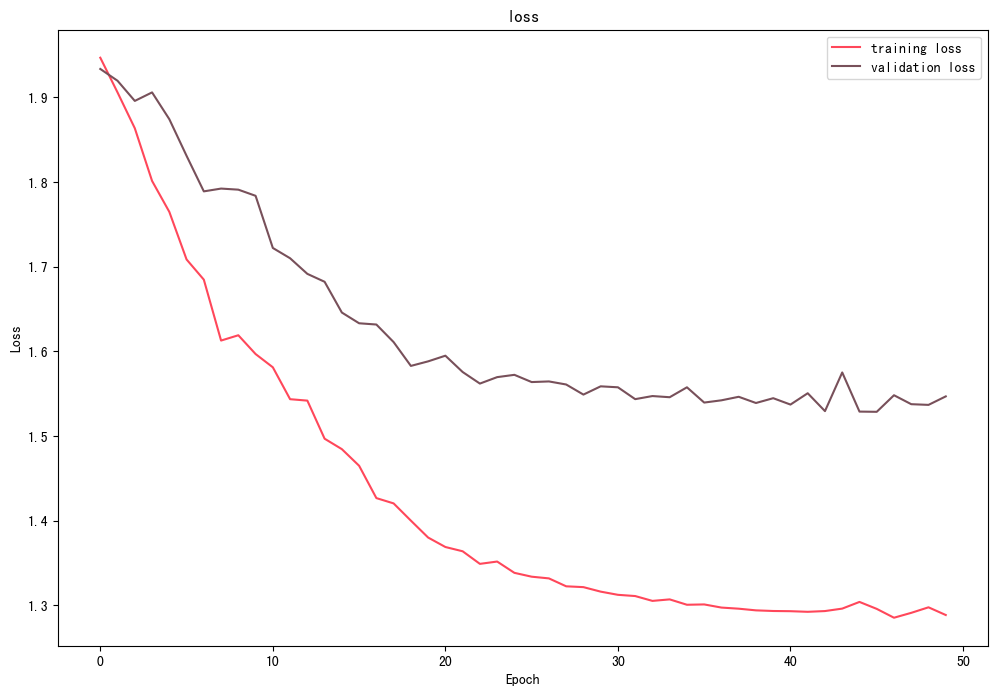

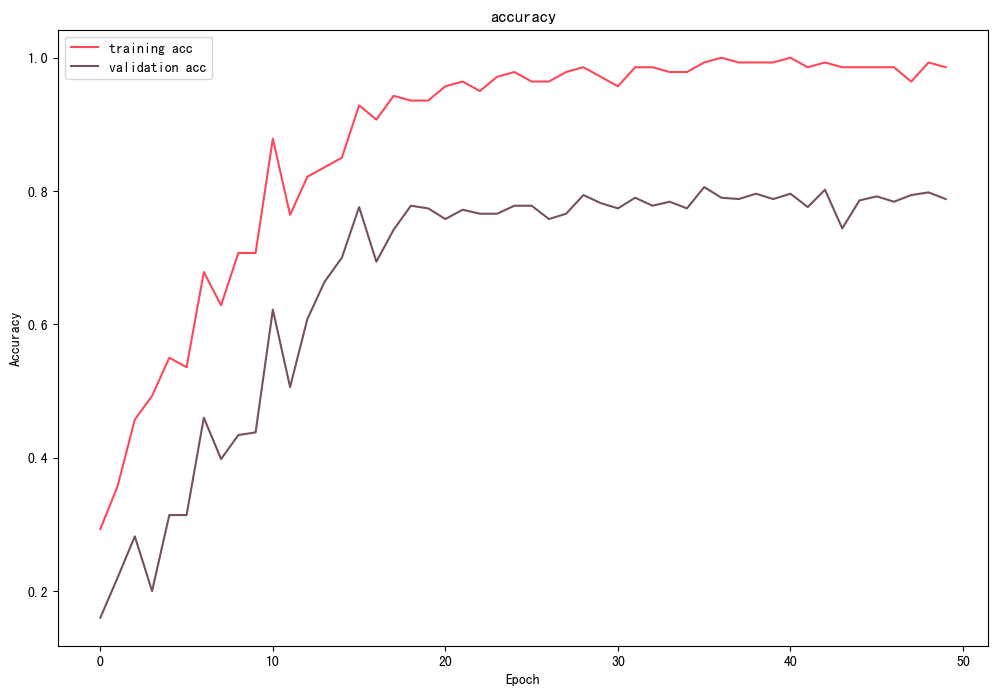

/home/zhoujianping/miniconda3/envs/torch3090/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhoujianping/miniconda3/envs/torch3090/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


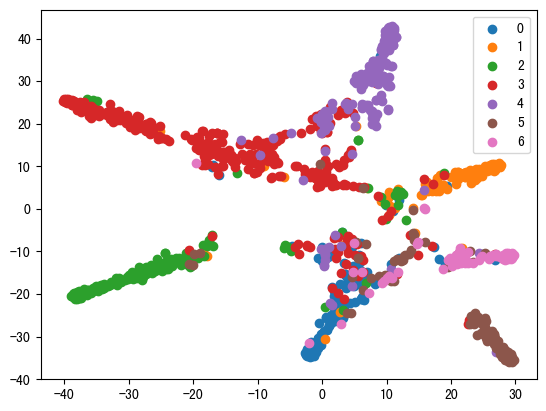

In [23]:
seed_torch(0)
# hyper params
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 50
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# DEVICE="cpu"
Data = namedtuple(
    'Data', ['x', 'y', 'adjacency', 'train_mask', 'val_mask', 'test_mask'])

# 加载数据，并转换为torch.Tensor
dataset = CoraData('../../GCN/Cora').data
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = torch.from_numpy(node_feature).to(DEVICE)
tensor_y = torch.from_numpy(dataset.y).to(DEVICE)
tensor_train_mask = torch.from_numpy(dataset.train_mask).to(DEVICE)
tensor_val_mask = torch.from_numpy(dataset.val_mask).to(DEVICE)
tensor_test_mask = torch.from_numpy(dataset.test_mask).to(DEVICE)
normalize_adjacency = CoraData.normalization(dataset.adjacency)  # 规范化邻接矩阵

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(
    np.asarray([normalize_adjacency.row,
                normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values,
                                            (num_nodes, num_nodes)).to(DEVICE)

# 模型定义：Model, Loss, Optimizer
model = GCN(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DACAY)


def train():
    model.train()
    train_loss_history = []
    train_acc_history = []
    val_acc_history = []
    val_loss_history = []
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]  # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)  # 计算损失值
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc, _, _, train_loss = test(tensor_train_mask, tensor_y)
        val_acc, _, _, val_loss = test(tensor_val_mask, tensor_y)
        train_loss_history.append(loss.item())
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())
        print(
            "epoch {:03d}: training loss {:.4f}, training acc {:.4}, validation acc {:.4f}"
            .format(epoch, loss.item(), train_acc.item(), val_acc.item()))
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


def test(mask, y):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        loss = criterion(test_mask_logits, y[mask])
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu(
    ).numpy(), loss


def plot_loss_with_acc(train_loss_history, train_acc_history, val_loss_history,
                       val_acc_history):
    # 因为一开始是GPU上的list，list的元素类型是tensor，因此要先转成cpu上的list
    train_acc_history=[item.cpu().numpy() for item in train_acc_history]
    val_loss_history=[item.cpu().numpy() for item in val_loss_history]
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(train_loss_history)),
             train_loss_history,
             c=np.array([255, 71, 90]) / 255.,
             label='training loss')
    plt.plot(range(len(val_loss_history)),
             val_loss_history,
             c=np.array([120, 80, 90]) / 255.,
             label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.title('loss')
    plt.savefig("../assets/loss.png")
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(range(len(train_acc_history)),
             train_acc_history,
             c=np.array([255, 71, 90]) / 255.,
             label='training acc')
    plt.plot(range(len(val_acc_history)),
             val_acc_history,
             c=np.array([120, 80, 90]) / 255.,
             label='validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.title('accuracy')
    plt.savefig("../assets/acc.png")
    plt.show()


train_loss, train_acc, val_loss, val_acc = train()
test_acc, test_logits, test_label, _ = test(tensor_test_mask, tensor_y)
print("Test accuarcy: ", test_acc.item())
plot_loss_with_acc(train_loss, train_acc, val_loss, val_acc)

# tsne visualize
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend(loc=0)
plt.savefig('../assets/tsne.png')
plt.show()